In [1]:
import sys
  
# append the path of the parent directory
sys.path.append("..")

from src.environment import BOWAPEnv
import matplotlib.pyplot as plt
import pygame
from src.utils import *
from src.pygame_utils import Hitbox, Hero
from src.models import Actor, Critic

pygame 2.1.2 (SDL 2.0.18, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
env = BOWAPEnv()

In [3]:
img = env.reset()

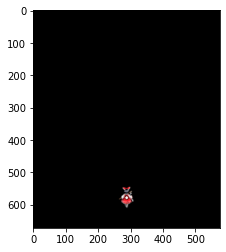

In [4]:
plt.imshow(img)

In [5]:
import torch

device = torch.device("cuda:0")
actor = Actor((120,120), env.action_space.n).to(device)
critic = Critic((120,120)).to(device).to(device)
actor.load_state_dict(torch.load("../weights/actor.pt"))
actor.eval()
critic.load_state_dict(torch.load("../weights/critic.pt"))
critic.eval()

Critic(
  (conv): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=14400, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
)

In [6]:
from torchvision.transforms import Resize
import time
start = time.time()
resize = Resize((120, 120))
state = env.reset()
# Preprocess state
imgs = [state]
state = (
    resize(torch.tensor(state).permute((2, 0, 1)).unsqueeze(0))
    .float()
    .to(device)
)
done = False
rewards = []

while not done:
    # Forward pass through Actor to get action probabilities
    with torch.no_grad():
        action_probs = actor(state)
    action = torch.multinomial(action_probs, 1).item()  # Sample action

    # Take action in the environment
    next_state, reward, done, _ = env.step(action)
    imgs.append(next_state)
    rewards.append(reward)

    # Preprocess next state
    state = (
        resize(torch.tensor(next_state).permute((2, 0, 1)).unsqueeze(0))
        .float()
        .to(device)
    )
end = time.time()
print(end - start)

65.7316575050354


In [7]:
sum(rewards)

210.9999999999907

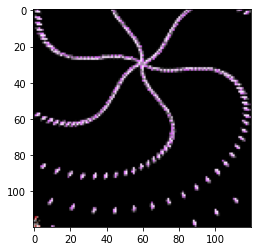

In [8]:
plt.imshow(state[0].permute((1, 2, 0)).cpu().numpy().astype(np.uint8))

In [9]:
img.shape

(672, 576, 3)

In [10]:
import cv2

video = cv2.VideoWriter("result.avi", 0, 60.0, (576, 672))

for image in imgs:
    video.write(image)

cv2.destroyAllWindows()
video.release()


In [11]:
hero_surface = pygame.Surface((72, 48))
reimu = Hero((24, 36))
hitbox = Hitbox((24, 42))
hero_surface.blit(reimu.image, reimu.rect)
hero_surface.blit(hitbox.image, hitbox.rect)

<rect(31, 17, 15, 15)>

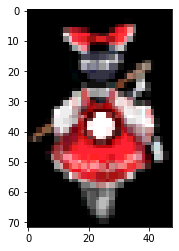

In [12]:
plt.imshow(pygame.surfarray.array3d(hero_surface))

In [13]:
from src.pygame_utils import play
play(env.log)